In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# last_date.__dict__
# print(last_date[0])
slice_yyyy = slice(4)
slice_mm = slice(5,7,1)
slice_dd = slice(8,10,1)
last_record = dt.date(int(last_date[0][slice_yyyy]), int(last_date[0][slice_mm]) ,int(last_date[0][slice_dd]))
# date 1 year ago from last_record
year_ago = dt.date(int(last_date[0][slice_yyyy]), int(last_date[0][slice_mm]) ,int(last_date[0][slice_dd])) - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
all_precip = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > year_ago).all()
all_precip

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(all_precip, columns=['date', 'prcp'])
df.set_index('date', inplace=True, )
df.sort_index()
df.head()



,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


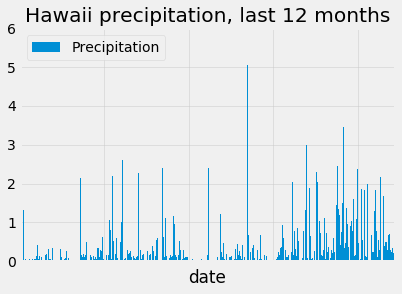

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.ticker as mticker

df.head()

fig, ax = plt.subplots()
df.plot.bar( y='prcp', width = 3, label="Precipitation", title="Hawaii precipitation, last 12 months", ax=ax)
ax.xaxis.set_major_locator(mticker.AutoLocator())
ax.xaxis.set_major_formatter(mticker.NullFormatter())
plt.grid(True, alpha=0.5)
plt.ylim(0, 6)
plt.show()




![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Get a list of regimens and calculate each stat individually
precp_count = df["prcp"].count()
precp_mean = round(df["prcp"].mean(),6)
precp_std = round(df["prcp"].std(),6)
precp_min = round(df["prcp"].min(),2)
precp_max = round(df["prcp"].max(),2)

# # Create summary table 
index = ["count", "mean", "std", "min", "max"]
stats = [precp_count, precp_mean, precp_std, precp_min, precp_max]
precip_summary_table = pd.DataFrame({"": index,
                                    "precipitation": stats})
precip_summary_table.set_index('', inplace=True, ) 
precip_summary_table

,precipitation
,
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
print(f"There are {session.query(Station).count()} stations in this dataset")

There are 9 stations in this dataset


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# group records by station and return the count of each station's records
station_counts = (session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station)).\
                  order_by(func.count(Measurement.station).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# confirm the position of most active station
most_active = station_counts[0][0]
print(most_active)
# get min, max and mean of most active station
min_temp = session.query(func.min(Measurement.tobs)).all()[0][0]
max_temp = session.query(func.max(Measurement.tobs)).all()[0][0]
mean_temp = session.query(func.avg(Measurement.tobs)).all()[0][0] 
print(min_temp)
print(max_temp)
print(mean_temp)

USC00519281
53.0
87.0
73.09795396419437


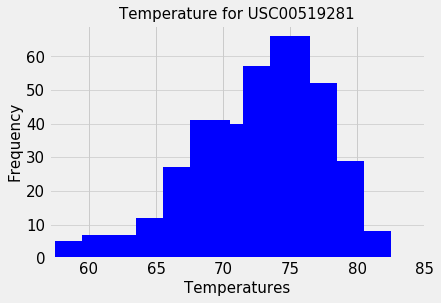

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query out temps for stations that == the most active station (calculated above)
st_temp = session.query(Measurement.tobs).\
        filter(Measurement.station == most_active).\
        filter(Measurement.date > year_ago).all()

# use list comprehension to unpack the tuple into a list of recorded temperatures
temps = [temp[0] for temp in st_temp]


# histogram the data
hist,bin_edges = np.histogram(temps, bins=12)
bin_edges

# use histogrammed data to produce a bar chart
plt.bar(bin_edges[:-1], hist, width = 3, color='blue',alpha=1)
plt.xlim(min(bin_edges)-2, max(bin_edges)+2)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Temperatures',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title(f'Temperature for {most_active}',fontsize=15)
plt.show()


![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# get start and end dates in specific format
user_start = input("What is your starting date in 'yyyy-mm-dd' format (must be before 2018-08-23)?")
user_end = input("What is your ending date in 'yyyy-mm-dd' format (must be before 2018-08-23)?")  

# return results from dates
results = calc_temps(user_start, user_end)
print(f"The min temperature for the previous year was: {results[0][0]}")
print(f"The average temperature for the previous year was: {round(results[0][1],1)}")
print(f"The max temperature for the previous year was: {round(results[0][2],1)}")

What is your starting date in 'yyyy-mm-dd' format (must be before 2018-08-23)? 2017-05-23
What is your ending date in 'yyyy-mm-dd' format (must be before 2018-08-23)? 2017-05-31


The min temperature for the previous year was: 69.0
The average temperature for the previous year was: 75.6
The max temperature for the previous year was: 87.0


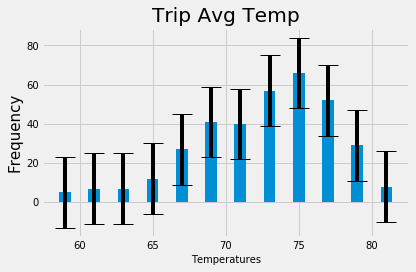

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = results[0][2] - results[0][0]

fig, ax = plt.subplots()
ax.bar(bin_edges[:-1], hist, yerr=error, align='center', alpha=1, ecolor='black', capsize=10)
plt.xlabel('Temperatures',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Frequency',fontsize=15)
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# combine measurements we want to return
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]

# query the db using the *sel and dates from above
station_total = (session.query(*sel).filter(Measurement.station == Station.station).\
                  filter(Measurement.date > user_start).\
                  filter(Measurement.date < user_end).\
                  group_by(Measurement.station).\
                  order_by(func.sum(Measurement.prcp).desc()).all())
                  
for record in station_total:
   
    print(record)


('USC00516128', 3.55, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519281', 2.1, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 1.48, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 1.2700000000000002, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00519397', 0.5700000000000001, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00514830', 0.23, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# ============================================
# Started but didn't have time to finish this section
# =================================================

# from dt import datetime
# normals = []
   

# Set the start and end date of the trip

# sdate = datetime.strptime(user_start, '%Y-%m-%d')
# edate = datetime.strptime(user_end, '%Y-%m-%d')
# delta = edate - sdate  
# # dates = range(delta.days)
# dates = []
# for i in range(delta.days + 1):
#     dates.append(sdate + datetime.timedelta(days=i))
# print(dates)


# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
